In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
import pandas as pd 
import numpy as np
import h5py
import sys
sys.path.append('/home/jma819/post_cmfe_analysis')
import python_utils_jjm as utils_jjm
import dlc_utils
import matplotlib.pyplot as plt
from matplotlib import animation, rc
import av
from tqdm import tqdm
import multiprocessing as mp
from itertools import product
plt.rcParams['animation.ffmpeg_path']='/home/jma819/.conda/envs/caiman/bin/ffmpeg'


In [2]:
#need to get keys first from all session dataframes to read into pandas 
h5file=pd.HDFStore('/projects/b1118/miniscope/analysis/event_analysis/mm_tracking_output/movement_regions_for_display.h5')
keys=h5file.keys()
h5file.close()

In [3]:
#load fluorescence in event regions
z_scored_events_by_session = {key_idx.strip('/'):pd.read_hdf('/projects/b1118/miniscope/analysis/event_analysis/mm_tracking_output/movement_regions_for_display.h5', 
                                                             key=key_idx) for key_idx in keys}

In [4]:
#load spatial components 
spatial_h5file=h5py.File('/projects/b1118/miniscope/analysis/spatial_data/spatial_components_test.h5', 'r')
spatial_contours = {session:spatial_h5file[session][:] for session in list(spatial_h5file.keys())}
spatial_h5file.close()

In [5]:
#spatial_contours_by_session

In [6]:
#load velocity data 
velocity_data = pd.read_hdf('/projects/b1118/miniscope/analysis/event_analysis/compiled_velocity_all_sessions_mm_tracking.h5')

In [7]:
velocity_data

velocity  \
GRIN035_H14_M40_S34 0 days 00:00:00         0.097739   
                    0 days 00:00:00.200000  0.194830   
                    0 days 00:00:00.400000  0.323540   
                    0 days 00:00:00.600000  0.128880   
                    0 days 00:00:00.800000  0.231460   
...                                              ...   
GRIN035_H13_M31_S20 0 days 00:22:36         0.187880   
                    0 days 00:22:36.200000  0.238950   
                    0 days 00:22:36.400000  0.000000   
                    0 days 00:22:36.600000  0.452920   
                    0 days 00:22:36.800000  0.344750   

                                            velocity(20_Hz_filtered)  index  \
GRIN035_H14_M40_S34 0 days 00:00:00                         0.050010      3   
                    0 days 00:00:00.200000                  0.034865      7   
                    0 days 00:00:00.400000                  0.022023     11   
                    0 days 00:00:00.600000                  0.000000     15   
                    0 days 00:00:00.800000                  0.000000     18   
...                                                              ...    ...   
GRIN035_H13_M31_S20 0 days 00:22:36                         0.000707  26416   
                    0 days 00:22:36.200000                  0.032991  26420   
                    0 days 00:22:36.400000                  0.062326  26424   
                    0 days 00:22:36.600000                  0.025053  26428   
                    0 days 00:22:36.800000                  0.000000  26429   

                                            frameNum  camNum  sysClock  \
GRIN035_H14_M40_S34 0 days 00:00:00                4       0       123   
                    0 days 00:00:00.200000         8       0       323   
                    0 days 00:00:00.400000        12       0       523   
                    0 days 00:00:00.600000        16       0       723   
                    0 days 00:00:00.800000        19       0       874   
...                                              ...     ...       ...   
GRIN035_H13_M31_S20 0 days 00:22:36            26417       0   1356189   
                    0 days 00:22:36.200000     26421       0   1356389   
                    0 days 00:22:36.400000     26425       0   1356588   
                    0 days 00:22:36.600000     26429       0   1356789   
                    0 days 00:22:36.800000     26430       0   1356839   

                                            buffer  behavCam_frames  \
GRIN035_H14_M40_S34 0 days 00:00:00              2                5   
                    0 days 00:00:00.200000       1               11   
                    0 days 00:00:00.400000       1               17   
                    0 days 00:00:00.600000       1               23   
                    0 days 00:00:00.800000       1               28   
...                                            ...              ...   
GRIN035_H13_M31_S20 0 days 00:22:36              1            37977   
                    0 days 00:22:36.200000       1            37984   
                    0 days 00:22:36.400000       1            37989   
                    0 days 00:22:36.600000       1            37996   
                    0 days 00:22:36.800000       1            37997   

                                            sys_clock_behavCam  \
GRIN035_H14_M40_S34 0 days 00:00:00                        128   
                    0 days 00:00:00.200000                 312   
                    0 days 00:00:00.400000                 520   
                    0 days 00:00:00.600000                 712   
                    0 days 00:00:00.800000                 888   
...                                                        ...   
GRIN035_H13_M31_S20 0 days 00:22:36                    1356176   
                    0 days 00:22:36.200000             1356399   
                    0 days 00:22:36.400000             1356576   
                    

In [8]:
session = 'GRIN038_H13_M37_S23'
dir_to_save = '/projects/b1118/miniscope/analysis/event_videos/mm_tracking_events/'
print(session)

GRIN038_H13_M37_S23


In [9]:
def create_compiled_event_videos_for_session(z_scored_events_by_session, velocity_data, spatial_contours, session, events_to_plot, cells_to_plot, save_dir, in_vmin=0, in_vmax=255):    
    """--create flags for selecting all cells/events or subset
        events_to_plot is tuple (event_start, event_end)
    """
    #loop over events here, loop over cells in function
    for event_bound in tqdm(events_to_plot):
        video_out, behav_cam_clip, cells_recombined, single_cell_response = create_event_video(event_bound[0], event_bound[1], velocity_data.loc[session], 
                                                                                    z_scored_events_by_session[session], 
                                                                                    spatial_contours[session][:, :], 
                                                                                    session, cells_to_plot, save_dir, in_vmin, in_vmax)  
    return(True)

In [10]:
def create_event_video(event_start, event_end, velocity_data_for_session, session_to_load, spatial_contours_by_session, session_name, cells, 
                       save_dir, in_vmin, in_vmax):
    #create time delta for msCam trace 
    time_delta_for_msCam_resampled = list(pd.timedelta_range(start=event_start, end=event_end, freq='.2S'))
    #find the closest frames to these in the behacCam data
    times_in_velocity_trace = [dlc_utils.nearest(velocity_data_for_session.index, time_delta_msCam) for time_delta_msCam in time_delta_for_msCam_resampled]
    #get the behav cam frame indicies for the times in times in velocity trace 
    behav_cam_indicies = [int(velocity_data_for_session.loc[td]['behavCam_frames']%1000) for td in times_in_velocity_trace]
    #get num of behavCam video
    behavCam_video = int((velocity_data_for_session.loc[times_in_velocity_trace[0]]['behavCam_frames'])/1000)+1
    behavCam_video_2 = int((velocity_data_for_session.loc[times_in_velocity_trace[-1]]['behavCam_frames'])/1000)+1
    #call function to get behavCam clip
    behav_cam_clip = load_and_return_behavCam_video(behav_cam_indicies, behavCam_video, session_name)
    
    all_cell_contours = spatial_contours_by_session[:, :]
    event_trace = session_to_load.loc['z_scored_movement_regions'].loc[event_start].loc[event_end]
    
    #get event movie for all cells
    cells_recombined = generate_event_movie_for_all_cells(event_trace, all_cell_contours)
    #get event movie for single cells
    ## now just run generate_event_movie_for_all_cells but with single cell 
    # for cell in columns from z scored movement dataframe 
    
    for cell in cells:
        single_cell_response = generate_cell_trace(cell, all_cell_contours, event_trace, (0, len(event_trace)))    
        anim_movie = generate_animation_function(behav_cam_clip, {behavCam_video:behav_cam_indicies}, cells_recombined, 
                                                 single_cell_response, event_trace[cell], session_name, event_start, cell, save_dir, 
                                                 in_vmin, in_vmax)
    return(anim_movie, behav_cam_clip, cells_recombined, single_cell_response)
    

In [11]:
def load_and_return_behavCam_video(behavCam_indicies_in_video, behavCam_video_to_load, session_to_load): 
    video = av.open('/projects/b1118/behaviorvideos/'+session_to_load+'/behavCam'+str(behavCam_video_to_load).zfill(2)+'DLC_resnet50_Open_Field_v2Jan27shuffle1_150000_labeled.mp4')
    total_frames = video.streams.video[0].frames
    movie_images = {}
    for i, frame in enumerate(video.decode(video=0)):
        img = frame.to_image()  # PIL image
        movie_images[i] = img
        if i%1000==0:
            print("Frame: %d/%d ..." % (i, total_frames))
    video.close()
    movie_shape = np.shape(movie_images[1])
    frame_subset = [movie_images[i] for i in behavCam_indicies_in_video]
    return(frame_subset)

In [12]:
def generate_event_movie_for_all_cells(event_trace, all_cell_contours, d1 = 752, d2 = 480):
    frame_range = (0, len(event_trace))
    cells_reshaped = np.empty((np.shape(all_cell_contours)[1], frame_range[1], d2, d1))
    for cell in tqdm(list(event_trace.columns)):
        # "spatial components", or "A" as dense matrix, cells are 1 indexed, spatial array is 0 indexed  
        A_reshaped = np.reshape(all_cell_contours[:, cell-1], (d2, d1))
        #cell_frames = []
        #for frame in range(frame_range[0], frame_range[1]):
        #cell_frames.append(np.array([np.dot(A_reshaped, item) for item in [255, 128, 0, z_scored_regions_by_session[session][sample][cell][frame]]]))
        cells_reshaped[cell-1] = np.array([np.dot(A_reshaped, event_trace[cell][frame]) for frame in range(frame_range[0], frame_range[1])])
    cells_recombined = np.sum(cells_reshaped, axis=0)
    return(cells_recombined)

In [13]:
##
def generate_cell_trace(cell_idx, all_cell_contours, event_trace, frame_range, d1 = 752, d2 = 480):
    A_reshaped = np.reshape(all_cell_contours[:, cell_idx-1], (d2, d1))
    #cells_reshaped[cell-1] = np.array([np.dot(A_reshaped, event_trace[cell][frame]) for frame in range(frame_range[0], frame_range[1])])
    cell_reshaped = np.array([np.dot(A_reshaped, event_trace[cell_idx][frame]) for frame in range(frame_range[0], frame_range[1])]) 
    return(cell_reshaped)

def wrap_for_map(list_input):
    
    A_reshaped = np.reshape(list_input[1][:, list_input[0]-1], (list_input[3], list_input[4]))
    cell_reshaped = np.array([np.dot(A_reshaped, list_input[2][list_input[0]][frame]) for frame in range(list_input[5][0], list_input[5][1])]) 
    return(cell_reshaped)
##

In [14]:
def generate_animation_function(behav_cam_clip, behavcaminfo, cells_recombined, single_cell_response, cell_trace, session, event_idx, cell, 
                                save_dir, in_vmin, in_vmax):
    """pass behavCam info as dictionary {'behavcamname':[frames]}"""
    #set up figure
    fig, ((ax1, ax2),(ax3,ax4)) = plt.subplots(2,2)
    plt.subplots_adjust(wspace=0.9)
    #plot initial frames
    #options for contrast diplay range
    if in_vmax=='norm_to_video':
        in_vmax = np.max(cells_recombined)
        in2_vmax = in_vmax
    elif in_vmax=='norm_to_each_video':
        in_vmax = np.max(cells_recombined)
        in2_vmax = np.max(single_cell_response)
    else:
        in2_vmax=in_vmax
            
    im = ax1.imshow(cells_recombined[0,:,:], cmap='gray', vmin=in_vmin, vmax=in_vmax)
    im2 = ax2.imshow(single_cell_response[0,:,:], cmap='gray', vmin=in_vmin, vmax=in2_vmax)
    ax3.plot(cell_trace)
    im4 = ax4.imshow(behav_cam_clip[0])
    #animation functions 
    def init():
        fig.suptitle("cell:"+str(cell)+"  frame:"+str(0))
        im.set_data(cells_recombined[0,:,:])
        im2.set_data(single_cell_response[0,:,:])
        ax4.set_title("behavCam: "+str(list(behavcaminfo.keys())[0])+"  frame: "+str(list(behavcaminfo.values())[0][0]))
        im4.set_data(behav_cam_clip[0])
    
    def animate(i):
        fig.suptitle("cell:"+str(cell)+"  frame:"+str(i))
        im.set_data(cells_recombined[i,:,:])
        im2.set_data(single_cell_response[i,:,:])
        ax4.set_title("behavCam: "+str(list(behavcaminfo.keys())[0])+"  frame: "+str(list(behavcaminfo.values())[0][i]))
        im4.set_data(behav_cam_clip[i])
        return (im, im2, im4)
    
    anim = animation.FuncAnimation(fig, animate, init_func=init, frames=cells_recombined.shape[0], interval=50)
    rc('animation', html='jshtml')
    mywriter = animation.FFMpegWriter(fps=5)
    anim.save(save_dir+session+'_event_'+str(event_idx)+'_cell_'+str(cell)+'.mp4', 
              writer=mywriter)
    plt.close()
    print('saved: '+save_dir+session+'_event_'+str(event_idx)+'_cell_'+str(cell)+'.mp4')
    return(anim)

In [15]:
## generate movie using functions 

In [16]:
print(session)
dir_to_save = '/projects/b1118/miniscope/analysis/event_videos/mm_tracking_events/'

GRIN038_H13_M37_S23


In [17]:
z_scored_events_by_session[session]

2    \
z_scored_movement_regions 0 days 00:00:03.400000 0 days 00:00:23.400000 0   2.876073   
                                                                        1   3.154966   
                                                                        2   4.088185   
                                                                        3   3.763889   
                                                                        4   3.465318   
...                                                                              ...   
z_scored_rest_regions     0 days 00:02:10.400000 0 days 00:02:30.400000 83  0.720733   
                                                                        84  0.696618   
                                                                        85  0.673309   
                                                                        86  0.650781   
                                                                        87  0.629006   

                                                                                 3    \
z_scored_movement_regions 0 days 00:00:03.400000 0 days 00:00:23.400000 0   0.000000   
                                                                        1   0.000000   
                                                                        2   0.000000   
                                                                        3   0.000000   
                                                                        4   0.000000   
...                                                                              ...   
z_scored_rest_regions     0 days 00:02:10.400000 0 days 00:02:30.400000 83  0.171015   
                                                                        84  0.206059   
                                                                        85  0.286326   
                                                                        86  0.270873   
                                                                        87  0.256254   

                                                                                 4    \
z_scored_movement_regions 0 days 00:00:03.400000 0 days 00:00:23.400000 0   0.011260   
                                                                        1   0.010560   
                                                                        2   0.091563   
                                                                        3   0.218863   
                                                                        4   0.356760   
...                                                                              ...   
z_scored_rest_regions     0 days 00:02:10.400000 0 days 00:02:30.400000 83  0.240650   
                                                                        84  0.287907   
                                                                        85  0.273465   
                                                                        86  0.259747   
                                                                        87  0.246718   

                                                                                 5    \
z_scored_movement_regions 0 days 00:00:03.400000 0 days 00:00:23.400000 0   0.232462   
                                                                        1   0.209944   
                                                                        2   0.189608   
                                                                        3   0.226461   
                                                                        4   0.204525   
...                                                                              ...   
z_scored_rest_regions     0 days 00:02:10.400000 0 days 00:02:30.400000 83  0.035947   
                                                                        84  0.034099   
                                                                        85  0.032347   
                              

In [18]:
event_start_indicies_in_session = utils_jjm.return_list_of_level_indicies_in_session(z_scored_events_by_session[session].loc['z_scored_movement_regions'], 0)
event_end_indicies_in_session = utils_jjm.return_list_of_level_indicies_in_session(z_scored_events_by_session[session].loc['z_scored_movement_regions'], 1)
event_start = event_start_indicies_in_session
event_end = event_end_indicies_in_session

In [19]:
event_bounds = [event_bound for event_bound in zip(event_start[:2], event_end[:2])]

In [20]:
event_bounds

[(Timedelta('0 days 00:00:03.400000'), Timedelta('0 days 00:00:23.400000')),
 (Timedelta('0 days 00:00:09'), Timedelta('0 days 00:00:29'))]

In [ ]:
##multiple events
create_compiled_event_videos_for_session(z_scored_events_by_session, velocity_data, spatial_contours, session, event_bounds, [21])

  0%|          | 0/2 [00:00<?, ?it/s]

Frame: 0/1000 ...



 35%|███▌      | 32/91 [00:17<00:33,  1.74it/s]

In [22]:
##single events 
#cell=22
anim_2, behav_cam_clip, cells_recombined, single_cell_response = create_event_video(event_start[0], event_end[0], 
                                                                                    velocity_data.loc[session], 
                                                                                    z_scored_events_by_session[session], 
                                                                                    spatial_contours[session], session, [21],
                                                                                    dir_to_save, 0, 'norm_to_each_video')

The history saving thread hit an unexpected error (OperationalError('disk I/O error')).History will not be written to the database.
Frame: 0/1000 ...


100%|██████████| 178/178 [01:40<00:00,  1.78it/s]


saved: /projects/b1118/miniscope/analysis/event_videos/mm_tracking_events/GRIN038_H13_M37_S23_event_0 days 00:00:03.400000_cell_21.mp4


In [23]:
anim_2

In [ ]:
## without functions 

In [26]:
velocity_data_for_session = velocity_data.loc[session]

event_start_indicies_in_session = utils_jjm.return_list_of_level_indicies_in_session(z_scored_events_by_session[session].loc['z_scored_movement_regions'], 0)
event_end_indicies_in_session = utils_jjm.return_list_of_level_indicies_in_session(z_scored_events_by_session[session].loc['z_scored_movement_regions'], 1)
event_start = event_start_indicies_in_session[1]
event_end = event_end_indicies_in_session[1]
#create time delta for msCam trace 
time_delta_for_msCam_resampled = list(pd.timedelta_range(start=event_start, end=event_end, freq='.2S'))
#find the closest frames to these in the behacCam data
times_in_velocity_trace = [dlc_utils.nearest(velocity_data_for_session.index, time_delta_msCam) for time_delta_msCam in time_delta_for_msCam_resampled]
# get the behav cam frame indicies for the times in times in velocity trace 
behav_cam_indicies = [int(velocity_data_for_session.loc[td]['behavCam_frames']%1000) for td in times_in_velocity_trace]
# get num of behavCam video
behavCam_video = int((velocity_data_for_session.loc[times_in_velocity_trace[0]]['behavCam_frames'])/1000)+1
behavCam_video_2 = int((velocity_data_for_session.loc[times_in_velocity_trace[-1]]['behavCam_frames'])/1000)+1
#call function to get behavCam clip
behav_cam_clip = load_and_return_behavCam_video(behav_cam_indicies, behavCam_video, session)
all_cell_contours = spatial_contours_by_session[session][:, :]
event_trace = z_scored_events_by_session[session].loc['z_scored_movement_regions'].loc[event_start].loc[event_end]
cells_recombined = generate_event_movie_for_all_cells(event_trace, all_cell_contours)

Frame: 0/1000 ...


100%|██████████| 91/91 [00:37<00:00,  2.40it/s]


In [27]:
## now just run generate_event_movie_for_all_cells but with single cell 
# for cell in columns from z scored movement dataframe 
cell = 21
single_cell_response = generate_cell_trace(cell, all_cell_contours, event_trace, (0, len(event_trace)))

In [28]:
#generate combined animation 
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2)
plt.subplots_adjust(wspace=0.3)

im = ax1.imshow(cells_recombined[0,:,:], cmap='gray', vmin=0, vmax=255)
im2 = ax2.imshow(single_cell_response[0,:,:], cmap='gray', vmin=0, vmax=255)
ax3.plot(z_scored_events_by_session[session].loc['z_scored_movement_regions'][cell].loc[event_start].loc[event_end])
im4 = ax4.imshow(behav_cam_clip[0])
plt.close()

def init():
    im.set_data(cells_recombined[0,:,:])
    im2.set_data(single_cell_response[0,:,:])
    im4.set_data(behav_cam_clip[0])
    
def animate(i):
    im.set_data(cells_recombined[i,:,:])
    im2.set_data(single_cell_response[i,:,:])
    im4.set_data(behav_cam_clip[i])
    return (im, im2, im4)
    
anim = animation.FuncAnimation(fig, animate, init_func=init, frames=cells_recombined.shape[0],
                               interval=50)
rc('animation', html='jshtml')


In [29]:
anim

In [16]:
event_trace = z_scored_events_by_session[session].loc['z_scored_movement_regions'].loc[event_start].loc[event_end]

d1 = 752
d2 = 480

frame_range = (0, len(event_trace))
cells_reshaped = np.empty((np.shape(all_cell_contours)[1], frame_range[1], d2, d1))
for cell in tqdm(list(event_trace.columns)):
    # "spatial components", or "A" as dense matrix, cells are 1 indexed, spatial array is 0 indexed  
    A_reshaped = np.reshape(all_cell_contours[:, cell-1], (d2, d1))
    #cell_frames = []
    #for frame in range(frame_range[0], frame_range[1]):
        #cell_frames.append(np.array([np.dot(A_reshaped, item) for item in [255, 128, 0, z_scored_regions_by_session[session][sample][cell][frame]]]))
    cells_reshaped[cell-1] = np.array([np.dot(A_reshaped, event_trace[cell][frame]) for frame in range(frame_range[0], frame_range[1])])
cells_recombined = np.sum(cells_reshaped, axis=0)

100%|██████████| 91/91 [00:51<00:00,  1.76it/s]


In [52]:
plt.plot(event_trace[10])

KeyError: 10

In [58]:
event_trace

1         2         3         4         5         6         7    \
0   -0.453001  0.335944  0.611605  0.281796 -0.534945 -0.613423 -0.888105   
1   -0.506015  0.299332  0.399161  0.127453 -0.534377 -0.614267 -0.888149   
2   -0.549411  0.584387  0.219751 -0.004320 -0.534483 -0.615578 -0.888177   
3   -0.584934  0.878910  0.068239 -0.116825 -0.534860 -0.616512 -0.888194   
4   -0.614012  0.746946 -0.059714 -0.212879 -0.535059 -0.617176 -0.888204   
..        ...       ...       ...       ...       ...       ...       ...   
102 -0.374164  1.607143 -0.751110 -0.648033 -0.535900 -0.614465 -0.887400   
103 -0.441483  1.409463  0.066640 -0.666410 -0.536039 -0.613311 -0.887717   
104 -0.496587  1.066010  0.032663 -0.682100 -0.536155 -0.612887 -0.887912   
105 -0.173778  0.781747 -0.089757 -0.695495 -0.536252 -0.612183 -0.887998   
106 -0.228207  4.376525 -0.193141 -0.706932 -0.536332 -0.611716 -0.887531   

          8         9         11   ...       105       106       109  \
0   -0.833773 -0.572369 -0.604215  ... -0.733892 -0.359114 -0.429623   
1   -0.831803 -0.572478 -0.600762  ... -0.742488 -0.358016 -0.429828   
2   -0.834315 -0.572743 -0.598576  ... -0.746413 -0.358318 -0.429989   
3   -0.835288 -0.572885 -0.599728  ... -0.748205 -0.357753 -0.430115   
4   -0.832092 -0.572821 -0.582260  ... -0.749023 -0.355506 -0.430214   
..        ...       ...       ...  ...       ...       ...       ...   
102 -0.838031 -0.571509 -0.609527  ... -0.749694 -0.352546 -0.427697   
103 -0.838184 -0.569566 -0.609858  ... -0.749703 -0.342688 -0.428318   
104 -0.838279 -0.569277 -0.610079  ... -0.749707 -0.347385 -0.428804   
105 -0.836048 -0.570637 -0.610226  ... -0.736271 -0.357844 -0.429186   
106 -0.833449 -0.569308 -0.606818  ... -0.738663 -0.361695 -0.429485   

          110       116       121       123       126       134       136  
0   -0.221421 -0.593166 -0.787829  0.048785 -0.491525 -0.333766  0.996038  
1   -0.220148 -0.604011 -0.791897 -0.065780 -0.486643 -0.376970  1.493927  
2   -0.220874 -0.627869 -0.790347  0.265390 -0.489403 -0.407956  0.745642  
3   -0.220990 -0.601717 -0.783738  0.223845 -0.468838 -0.430179  0.100475  
4   -0.218205 -0.591818 -0.790829 -0.227050 -0.483507 -0.446117 -0.289471  
..        ...       ...       ...       ...       ...       ...       ...  
102 -0.221025 -0.640111 -0.799987  0.099120 -0.447945 -0.151913 -0.337612  
103 -0.221686 -0.640870 -0.800616  0.329810 -0.444248 -0.246547 -0.241955  
104 -0.220695 -0.641143 -0.767029  0.873833 -0.442887 -0.314418 -0.084036  
105 -0.220345 -0.641241 -0.779708  0.287508 -0.420921 -0.363094 -0.262357  
106 -0.220515 -0.641277 -0.790278 -0.190967 -0.448578 -0.197434 -0.508771  

[107 rows x 91 columns]

In [82]:
event_trace.iloc[:,list(np.where(event_trace.max(axis=0)>5)[0])]

21        22        24        28        30        32        45  \
0    0.279630 -0.020623 -0.596515 -0.910647 -0.977104 -0.434806 -0.181421   
1    0.425188 -0.049399 -0.828779 -0.911420 -0.979463 -0.403211 -0.234625   
2    0.274097  0.582724 -0.996573 -0.912076 -0.981473 -0.439200 -0.278425   
3    0.277957  0.348962 -1.117792 -0.912633 -0.983185 -0.466659 -0.263671   
4   -0.084993  0.638113 -1.205364 -0.913105 -0.984644 -0.487610 -0.411298   
..        ...       ...       ...       ...       ...       ...       ...   
102  0.233813 -0.836496  0.051341 -0.083329 -0.081437  1.663376 -0.063617   
103 -0.213164 -0.306008  0.648502 -0.116872 -0.216381  4.067842 -0.222068   
104 -0.512247 -0.223437  0.336146 -0.238062 -0.331349  6.670649 -0.381259   
105 -0.169245 -0.343669 -0.154999 -0.340867 -0.176824  5.756453 -0.496203   
106 -0.259826 -0.535982 -0.509815 -0.428076  0.555137  4.260421 -0.162167   

           47        55        58        59        60        68        70  \
0   -0.679683 -0.002585 -0.497224  0.736005 -0.182130 -0.731594 -0.227545   
1   -0.699105 -0.170469 -0.497265  0.528004 -0.201341 -0.796729 -0.250550   
2   -0.714646 -0.091959 -0.497298  0.286414 -0.219192 -0.843417 -0.291892   
3   -0.727081  0.119451 -0.497325  0.080177 -0.235780 -0.876880 -0.262411   
4   -0.737032 -0.074924 -0.497347 -0.095881  0.215149 -0.900866 -0.292757   
..        ...       ...       ...       ...       ...       ...       ...   
102 -0.496123  1.071850 -0.395688 -1.117933 -0.171182 -0.844910 -0.091412   
103 -0.552223  0.670732 -0.414751 -1.118668 -0.191168 -0.877951 -0.154030   
104 -0.597113  0.356687 -0.430243 -1.119295 -0.209739 -0.901633 -0.208277   
105 -0.633033  0.705663 -0.442833 -1.119830 -0.226996 -0.837988 -0.255271   
106 -0.661776  2.718749 -0.453064 -1.120287 -0.243032 -0.189715 -0.295981   

           78        80        95  
0   -0.587483  0.151605  2.748110  
1   -0.643985 -0.028313  2.071497  
2   -0.683066 -0.176106  1.520953  
3   -0.710098 -0.297510  1.072988  
4   -0.728795 -0.397237  0.708489  
..        ...       ...       ...  
102 -0.515058 -0.560231  3.662725  
103 -0.593890  1.911283  2.815698  
104 -0.648416  4.008004  2.126492  
105 -0.686131  5.209281  1.565701  
106 -0.712218  4.126298  1.109399  

[107 rows x 17 columns]

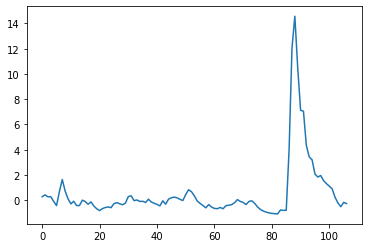

In [83]:
plt.plot(event_trace[21])

In [74]:
event_trace[[1,2]]

1         2
0   -0.453001  0.335944
1   -0.506015  0.299332
2   -0.549411  0.584387
3   -0.584934  0.878910
4   -0.614012  0.746946
..        ...       ...
102 -0.374164  1.607143
103 -0.441483  1.409463
104 -0.496587  1.066010
105 -0.173778  0.781747
106 -0.228207  4.376525

[107 rows x 2 columns]